<a href="https://colab.research.google.com/github/zentralwerkstatt/pittsburgh/blob/main/pittsburgh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Clustering with Large Visual Models

**This notebook requires a GPU - make sure to change the runtime type in the "runtime" menu!**

**Background reading: https://www.tandfonline.com/doi/full/10.1080/01973762.2024.2362466**

## Setup

Download a toolbox of utility functions (including its dependencies) as well as OpenAI's CLIP model.

In [ ]:
%%capture
!rm -rf toolbox # Remove if we have downloaded before
!git clone https://github.com/zentralwerkstatt/toolbox # Clone and install CLIP Github repository
!pip3 install git+https://github.com/openai/CLIP.git
!pip3 install umap-learn filetype # Install some dependencies

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning) # Silence some usual warnings
warnings.filterwarnings("ignore",category=FutureWarning)

Import the libraries we will need:
* `numpy` is a library for matrix operations. It is needed for almost all machine learning applications. We will call it `np` from here on out to save some space.
* `PIL` (pillow) gives us access to easy image manipulation primitives through the `Image` interface.
* `tqdm` gives us a progress bar.
* `KMeans` is an implementation of a centroid-based clustering algorithm that partitions a dataset into similar groups based on the distance between their centroids. It is provided here by the `scikit-learn` library.
* `toolbox` (written by Fabian Offert) contains useful utility functions for digital visual humanities research.



In [ ]:
import numpy as np
import PIL.Image
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans
from toolbox import toolbox

100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 56.6MiB/s]


Get some test data: a subset of the [Web gallery of art](https://www.wga.hu/) dataset consisting of 1100 landscape paintings and 1100 portrait paintings. We will download this data as a ZIP archive and extract it to our virtual hard disk.


In [ ]:
%%capture
!rm -rf wga # Remove if we have downloaded before
!gdown --id 10eyHTKDDqN7iwu0WDCaq2sZtOCQ3w9Fs # Download from Google Drive
!unzip wga.zip -d . # Unzip to current working directory
!rm wga.zip # Remove ZIP file

Now we are ready to go!

## Clustering images...

First, load the WGA dataset...

In [ ]:
paths = toolbox.get_all_files("wga", ext="jpg") # Get the paths of all files in the dataset
print(paths[:5]) # Check to see if paths have been loaded

['wga/train/portrait/99.jpg', 'wga/train/portrait/244.jpg', 'wga/train/portrait/655.jpg', 'wga/train/portrait/247.jpg', 'wga/train/portrait/871.jpg']


... then, check to see how many images we will work with.

In [ ]:
len(paths)

2200

Let's try everything with a small subset first.

In [ ]:
paths = paths[:100] # Just use the first 100 images

### ... by "brightness"

Extract the features by "flattening" the image - we are simply concatenating all color values into one huge list.

In [ ]:
features = np.zeros((len(paths), 32*32*3)) # Make an empty numpy array
for i, path in enumerate(tqdm(paths)): # Move through all the paths
    img = toolbox.load_img(path) # Load the image from disk
    features[i] = toolbox.flatten_img(img, 32) # The second parameter resizes the image

  0%|          | 0/2200 [00:00<?, ?it/s]

This gives us 3072-dimensional features, we have to reduce them down to Euclidean space somehow.

In [ ]:
print(features.shape) # We check the dimensions of a numpy array with the shape function

(2200, 3072)


We will use the [UMAP algorithm](https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction#Uniform_manifold_approximation_and_projection) for this.

In [ ]:
reduced_features = toolbox.reduce_features(features) # This uses UMAP by default
print(reduced_features.shape)

(2200, 2)


Now let's see how that looks

In [ ]:
plot = toolbox.plot_imgs_features(paths, 30, reduced_features) # The second parameter resizes the image

  0%|          | 0/2200 [00:00<?, ?it/s]

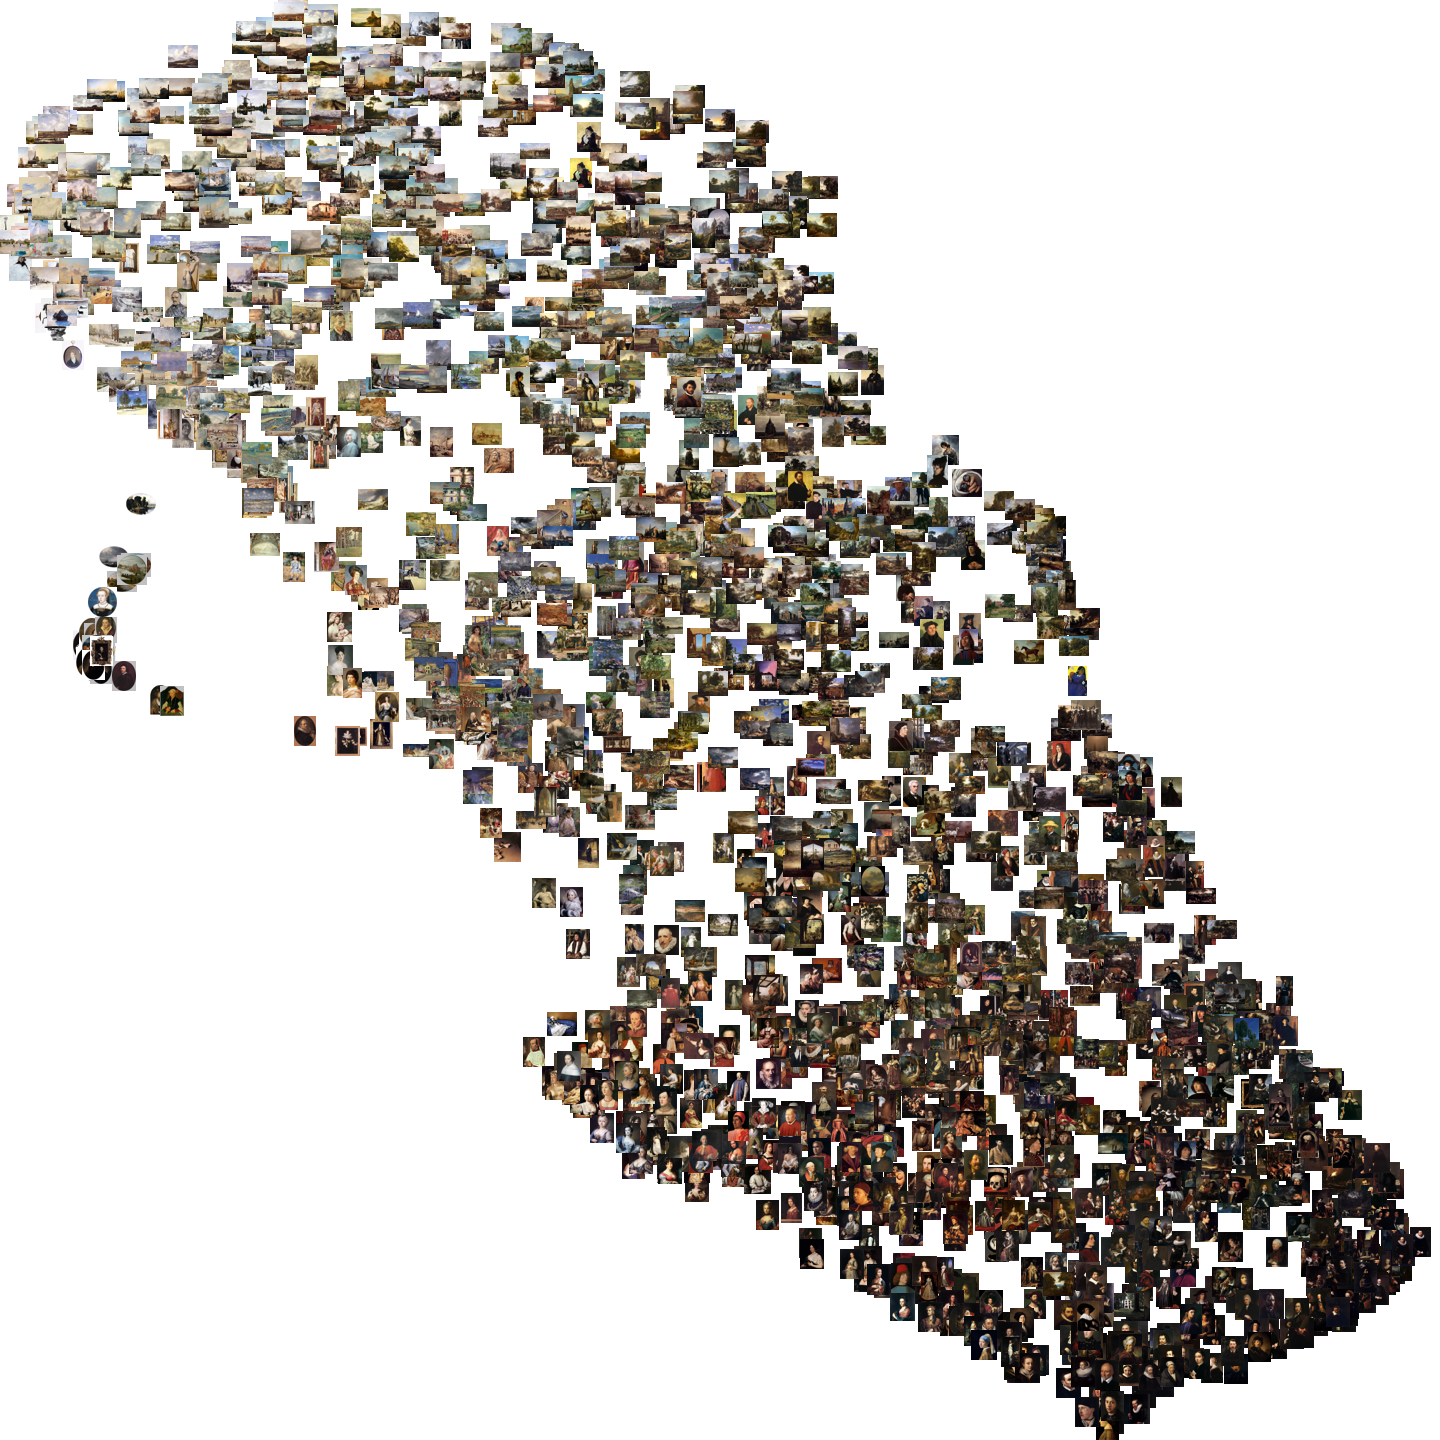

In [ ]:
plot

In [ ]:
plot.save("plot_raw.jpg")

### ... using CLIP

Usually, however, color will not tell us much about an image dataset. Instead, we can leverage state-of-the-art, fully-trained neural networks, like [CLIP](https://openai.com/blog/clip/), that know something about the *content* of images.

In [ ]:
features = np.zeros((len(paths), 512))
for i, path in enumerate(tqdm(paths)):
    img = toolbox.load_img(path)
    features[i] = toolbox.CLIP_img(img)

  0%|          | 0/2200 [00:00<?, ?it/s]

In [ ]:
print(features.shape)

(100, 512)


CLIP gives us 512-dimensional embeddings, we have to reduce them down to Euclidean space somehow. Again we will use the UMAP algorithm.

In [ ]:
reduced_features = toolbox.reduce_features(features)
print(reduced_features.shape)

(2200, 2)


In [ ]:
plot = toolbox.plot_imgs_features(paths, 30, reduced_features)

  0%|          | 0/2200 [00:00<?, ?it/s]

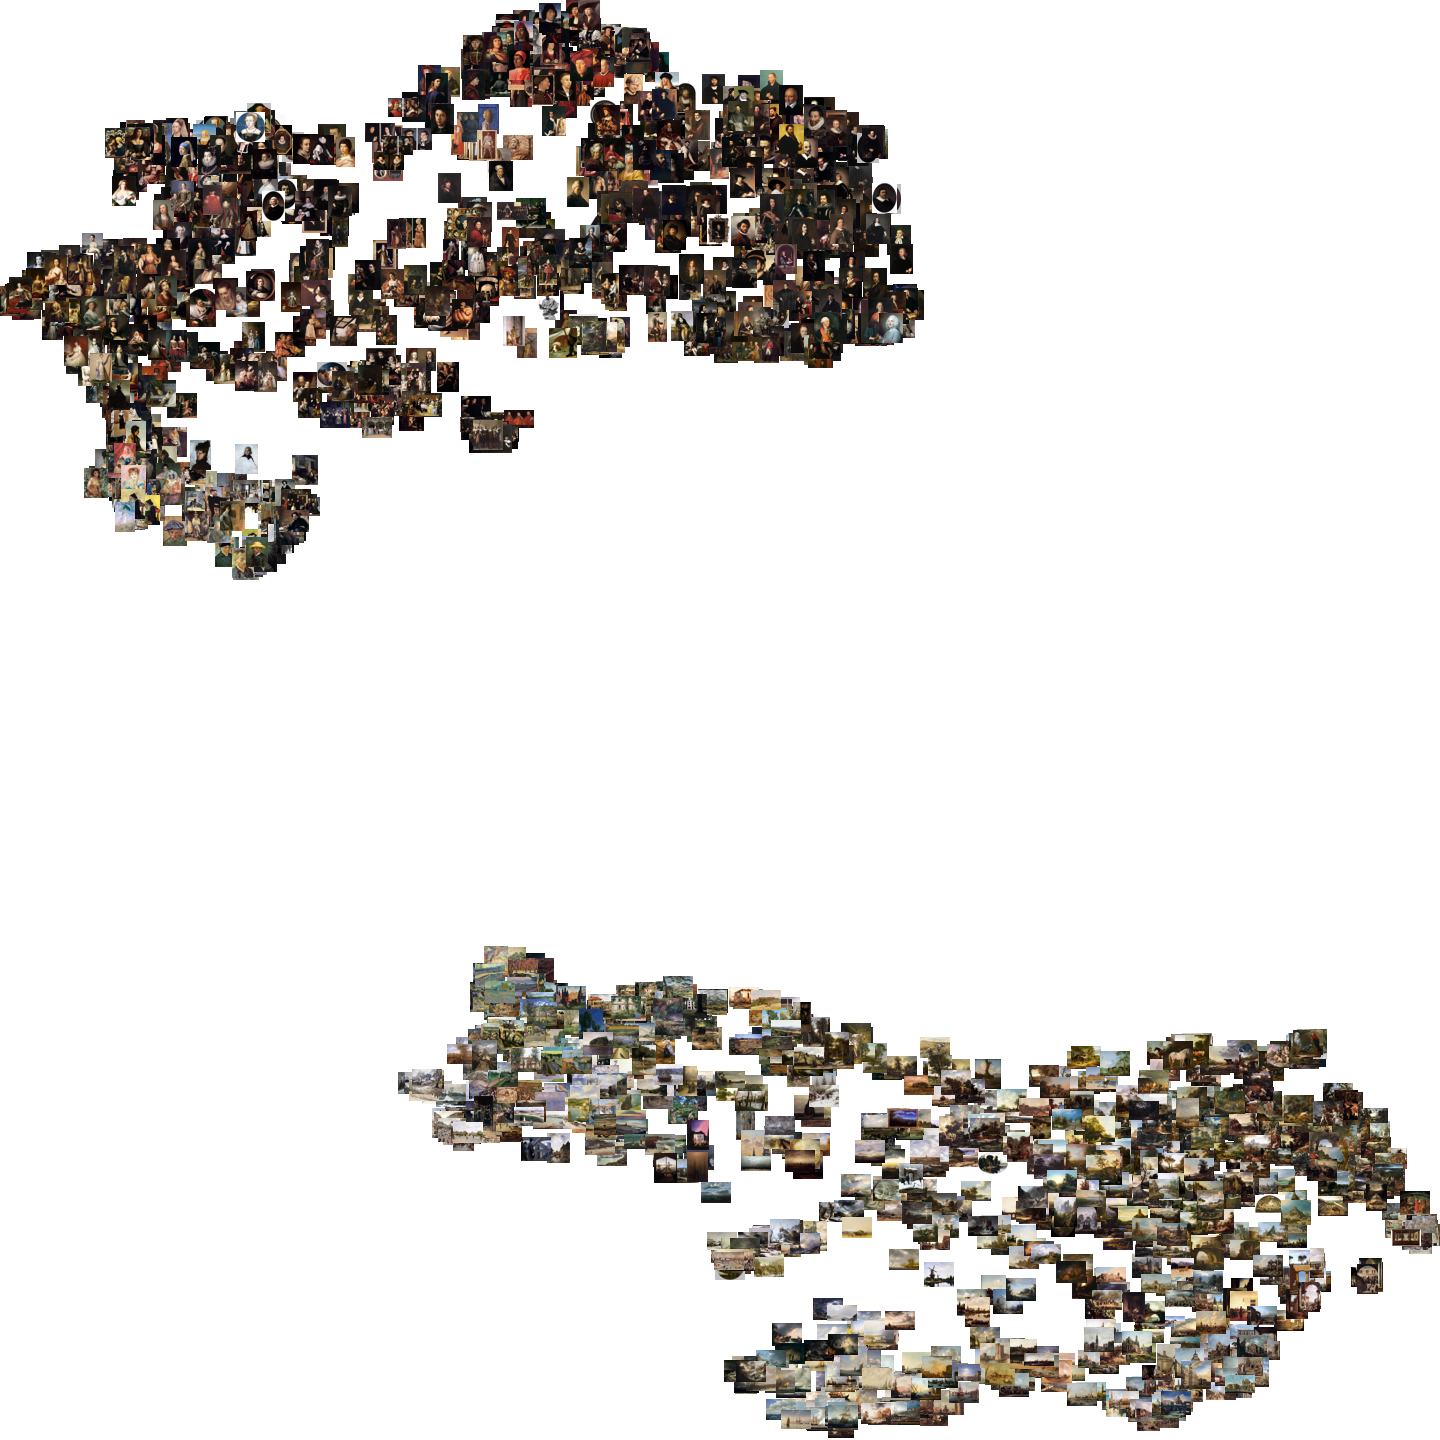

In [ ]:
plot

In [ ]:
plot.save("plot_clip.jpg")

## Advanced clustering

There are many interesting clusters that we can see in the plot – can we automate this process, too?

In [ ]:
n_clusters = 20 # KMeans needs us to tell it how many clusters we are looking for!

In [ ]:
km = KMeans(n_clusters=n_clusters)
km.fit(features)

KMeans(n_clusters=20)

In [ ]:
km.labels_.shape # Each image now has a label that assigns it to a cluster

(2200,)

We are trying to find 5 clusters in 2200 images - here is what the algorithm found.

In [ ]:
km.labels_[:100]

array([15,  4,  2, 15,  1,  4,  8,  4,  0, 18, 19, 18, 10, 18,  2, 18, 19,
       18, 15, 10,  8,  0,  4, 16, 19,  0,  8, 11,  0,  8,  0, 11,  4, 18,
       19,  8, 18, 16,  0, 13,  5,  4, 15,  8, 10, 11, 10,  6,  2,  0, 16,
       16,  0, 13, 18, 18, 18,  2, 10,  2, 11, 13, 11, 18, 13, 10,  0,  8,
       11,  4, 13,  2, 19,  2,  2, 11, 18, 15, 15,  5, 10,  0,  8, 10,  8,
       11, 11,  2, 18, 10, 15,  4, 18,  4, 13,  2,  5,  5, 11, 10],
      dtype=int32)

Let's try to visualize this.

In [ ]:
clusters = {}
for c in range(n_clusters): # For each cluster...
    clusters[c] = [] #... make new list.
    for i, path in enumerate(paths): # For each image ...
        if km.labels_[i] == c: # ... if it belongs to the current cluster ...
            clusters[c].append(path) # ... add the path to the list.

In [ ]:
for c in range(n_clusters): # For each cluster...
    toolbox.show_img(toolbox.plot_imgs_grid(clusters[c], 50)) # ... plot all associated images as a grid.

No we can visualize where the clusters are in the overview plot.

In [ ]:
borders = []
p = toolbox.random_palette(n_clusters) # Create a random palette that has as many colors as we have clusters
for i, path in enumerate(paths):
    borders.append(p[km.labels_[i]]) # Color all images according to their clusters.

In [ ]:
plot = toolbox.plot_imgs_features(paths, 30, reduced_features, borders)

  0%|          | 0/2200 [00:00<?, ?it/s]

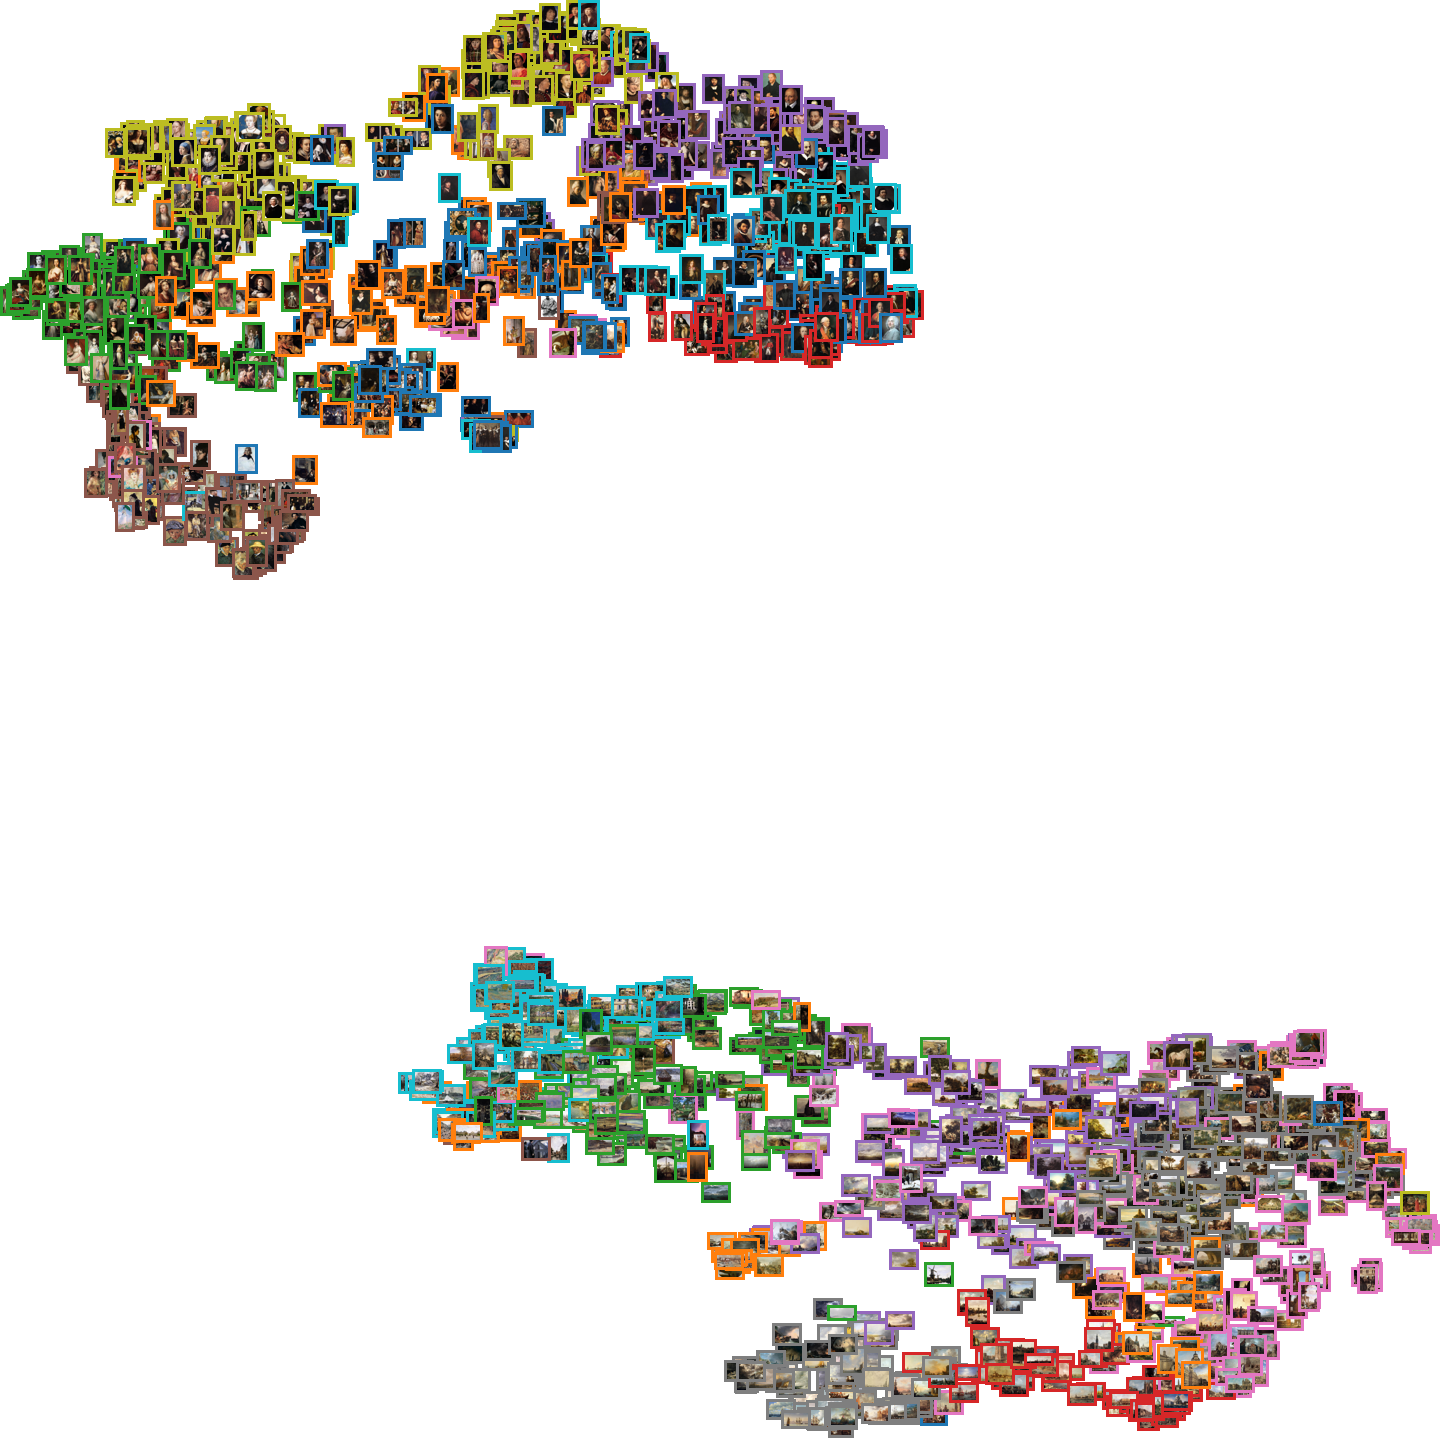

In [ ]:
plot

In [ ]:
plot.save("plot_clip_borders_clusters.jpg")